In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import sklearn
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
train_df=pd.read_csv("train.csv", index_col='id')
test_df=pd.read_csv("test.csv", index_col='id')

In [3]:
'''get training feat'''

non_float_columns = train_df.select_dtypes(exclude=['float']).columns
categorical_features = list(non_float_columns)
categorical_features.remove('NObeyesdad')

float_columns = train_df.select_dtypes(include=['float']).columns
numerical_features = list(float_columns)

target = 'NObeyesdad'

In [4]:
class ExtendedLabelEncoder(LabelEncoder):
    def transform(self, y):
        unseen_labels = set(y) - set(self.classes_)
        if unseen_labels:
            # 动态扩展 classes_
            self.classes_ = np.append(self.classes_, list(unseen_labels))
        return super().transform(y)

# 初始化扩展版 LabelEncoder
label_encoder = ExtendedLabelEncoder()
encoding_mapping = {}

for column in non_float_columns:
    # 对训练集进行 fit_transform
    train_df[column] = label_encoder.fit_transform(train_df[column])
    encoding_mapping[column] = dict(enumerate(label_encoder.classes_))
    if column != 'NObeyesdad':
        # 对测试集进行 transform
        test_df[column] = label_encoder.transform(test_df[column])

In [5]:
print("训练集编码完成:------------------")
print(train_df.head())
print("测试集编码完成:------------------")
print(test_df.head())

训练集编码完成:------------------
    Gender        Age    Height      Weight  family_history_with_overweight  \
id                                                                            
0        1  24.443011  1.699998   81.669950                               1   
1        0  18.000000  1.560000   57.000000                               1   
2        0  18.000000  1.711460   50.165754                               1   
3        0  20.952737  1.710730  131.274851                               1   
4        1  31.641081  1.914186   93.798055                               1   

    FAVC      FCVC       NCP  CAEC  SMOKE      CH2O  SCC       FAF       TUE  \
id                                                                             
0      1  2.000000  2.983297     2      0  2.763573    0  0.000000  0.976473   
1      1  2.000000  3.000000     1      0  2.000000    0  1.000000  1.000000   
2      1  1.880534  1.411685     2      0  1.910378    0  0.866045  1.673584   
3      1  3.000000 

In [6]:
encoding_mapping

{'Gender': {0: 'Female', 1: 'Male'},
 'family_history_with_overweight': {0: 'no', 1: 'yes'},
 'FAVC': {0: 'no', 1: 'yes'},
 'CAEC': {0: 'Always', 1: 'Frequently', 2: 'Sometimes', 3: 'no'},
 'SMOKE': {0: 'no', 1: 'yes'},
 'SCC': {0: 'no', 1: 'yes'},
 'CALC': {0: 'Frequently', 1: 'Sometimes', 2: 'no'},
 'MTRANS': {0: 'Automobile',
  1: 'Bike',
  2: 'Motorbike',
  3: 'Public_Transportation',
  4: 'Walking'},
 'NObeyesdad': {0: 'Insufficient_Weight',
  1: 'Normal_Weight',
  2: 'Obesity_Type_I',
  3: 'Obesity_Type_II',
  4: 'Obesity_Type_III',
  5: 'Overweight_Level_I',
  6: 'Overweight_Level_II'}}

In [7]:
# 初始化扩展版 LabelEncoder
class ExtendedLabelEncoder(LabelEncoder):
    def transform(self, y):
        unseen_labels = set(y) - set(self.classes_)
        if unseen_labels:
            self.classes_ = np.append(self.classes_, list(unseen_labels))
        return super().transform(y)

label_encoder = ExtendedLabelEncoder()

In [8]:
class DataPreprocessor:
    def __init__(self, train_df, test_df, target, label_encoder):
        self.train_df = train_df
        self.test_df = test_df
        self.target = target
        self.label_encoder = label_encoder
        self.categorical_features = []
        self.numerical_features = []
        self.encoding_mapping = {}
        self.non_float_columns = []


    def process_data(self):
        # 获取类别型和数值型特征
        self.non_float_columns = self.train_df.select_dtypes(exclude=['float']).columns
        self.categorical_features = list(non_float_columns)
        self.categorical_features.remove(self.target)  # 排除目标列

        float_columns = self.train_df.select_dtypes(include=['float']).columns
        self.numerical_features = list(float_columns)


        # 对训练集进行编码
        for column in self.non_float_columns:
            self.train_df[column] = self.label_encoder.fit_transform(self.train_df[column])
            self.encoding_mapping[column] = dict(enumerate(self.label_encoder.classes_))
            if column != self.target:
                # 对测试集进行 transform
                self.test_df[column] = self.label_encoder.transform(self.test_df[column])

        return self.train_df, self.test_df, self.encoding_mapping

In [9]:

class CustomDataset(Dataset):
    def __init__(self, data_frame, categorical_features, numerical_features, target, encoding_mapping=None):
        """
        :param data_frame: pandas DataFrame 数据
        :param categorical_features: 类别型特征的列名
        :param numerical_features: 数值型特征的列名
        :param target: 目标列名
        :param encoding_mapping: 可选，类别型特征的编码映射
        """
        self.data_frame = data_frame
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.target = target
        self.encoding_mapping = encoding_mapping

    def __len__(self):
        # 返回数据集的大小
        return len(self.data_frame)

    def __getitem__(self, idx):
        """
        返回数据集中的第 idx 项数据
        :param idx: 数据索引
        :return: 数据样本和标签
        """
        # 获取每一行数据
        row = self.data_frame.iloc[idx]

        # 获取特征
        categorical_data = row[self.categorical_features].values
        numerical_data = row[self.numerical_features].values

        # 将数据转化为张量
        categorical_data = torch.tensor(categorical_data, dtype=torch.long)
        numerical_data = torch.tensor(numerical_data, dtype=torch.float32)

        # 获取目标值
        # target = row[self.target]
        # 如果 row[self.target] 是浮点数类型，强制转换为整数
        target = torch.tensor(int(row[self.target]), dtype=torch.long)  # 分类任务标签为整数


        return {'categorical': categorical_data, 'numerical': numerical_data, 'target': target}


# 使用自定义 Dataset 类
def create_dataloader(train_df, categorical_features, numerical_features, target, batch_size, shuffle=True):

    dataset = CustomDataset(train_df, categorical_features, numerical_features, target)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return dataloader


In [10]:
from sklearn.model_selection import train_test_split

batch_size = 32 #default


data_processor = DataPreprocessor(train_df,test_df,target = 'NObeyesdad', label_encoder = label_encoder)

train_df_processed , test_df_processed , encoding_mapping = data_processor.process_data()

# 假设 train_df 是已经处理过的数据框
train_dfm, val_dfm = train_test_split(train_df_processed, test_size=0.2, random_state=42)


# 创建数据加载器
train_dataloader = create_dataloader(train_dfm,
                                     batch_size = batch_size,
                                     categorical_features=data_processor.categorical_features,
                                     numerical_features=data_processor.numerical_features,
                                     target=data_processor.target)

val_dataloader = create_dataloader(val_dfm,
                                     batch_size = batch_size,
                                     categorical_features=data_processor.categorical_features,
                                     numerical_features=data_processor.numerical_features,
                                     target=data_processor.target)



In [11]:
print(train_df_processed.head())
print(train_dfm.shape , val_dfm.shape)

    Gender        Age    Height      Weight  family_history_with_overweight  \
id                                                                            
0        1  24.443011  1.699998   81.669950                               1   
1        0  18.000000  1.560000   57.000000                               1   
2        0  18.000000  1.711460   50.165754                               1   
3        0  20.952737  1.710730  131.274851                               1   
4        1  31.641081  1.914186   93.798055                               1   

    FAVC      FCVC       NCP  CAEC  SMOKE      CH2O  SCC       FAF       TUE  \
id                                                                             
0      1  2.000000  2.983297     2      0  2.763573    0  0.000000  0.976473   
1      1  2.000000  3.000000     1      0  2.000000    0  1.000000  1.000000   
2      1  1.880534  1.411685     2      0  1.910378    0  0.866045  1.673584   
3      1  3.000000  3.000000     2      0  1.6

In [12]:
# 训练循环时访问字典中的数据
for batch in train_dataloader:
    # 访问字典中的数据
    X_categorical = batch['categorical']   # 类别型特征
    X_numerical = batch['numerical']       # 数值型特征
    y = batch['target']
    # 目标标签
    print('target :' , target)

    print(f'X_categorical :{X_categorical.shape}')
    print(f'X_numerical :{X_numerical.shape}')
    print(f'y :{y.shape}')
    break


target : NObeyesdad
X_categorical :torch.Size([32, 8])
X_numerical :torch.Size([32, 8])
y :torch.Size([32])


In [13]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomModel, self).__init__()

        # Encoder部分
        self.encoder_layer1 = nn.Linear(input_dim, 64)
        self.encoder_layer2 = nn.Linear(64, 8)

        # Decoder部分
        self.decoder_layer1 = nn.Linear(8, 32)
        self.decoder_output = nn.Linear(32, input_dim)  # Decoder输出大小与输入大小一致

        # 分类任务
        self.autoencoder_classification1 = nn.Linear(input_dim, 64)
        self.autoencoder_classification2 = nn.Linear(64, num_classes)  # 输出7类

        # 分类任务
        self.mlp_layer1 = nn.Linear(input_dim + 8, 64)
        self.mlp_layer2 = nn.Linear(64, 32)
        self.final_output = nn.Linear(32, num_classes)  # 输出7类

    def forward(self, x):
        # Encoder部分
        encoded = F.relu(self.encoder_layer1(x))
        encoded = F.relu(self.encoder_layer2(encoded))

        # Decoder部分
        decoded = F.relu(self.decoder_layer1(encoded))
        decoded_output = self.decoder_output(decoded)

        # 分类任务
        autoencoder_linear = self.autoencoder_classification1(decoded_output)
        autoencoder_classification = F.softmax(self.autoencoder_classification2(autoencoder_linear), dim=-1)

        # MLP分类任务
        mlp_input = torch.cat([x, encoded], dim=1)
        mlp = F.relu(self.mlp_layer1(mlp_input))
        mlp = F.relu(self.mlp_layer2(mlp))
        final_output = F.softmax(self.final_output(mlp), dim=-1)

        return autoencoder_classification, final_output, decoded_output


CustomModel(
  (encoder_layer1): Linear(in_features=16, out_features=64, bias=True)
  (encoder_layer2): Linear(in_features=64, out_features=8, bias=True)
  (decoder_layer1): Linear(in_features=8, out_features=32, bias=True)
  (decoder_output): Linear(in_features=32, out_features=16, bias=True)
  (autoencoder_classification1): Linear(in_features=16, out_features=64, bias=True)
  (autoencoder_classification2): Linear(in_features=64, out_features=7, bias=True)
  (mlp_layer1): Linear(in_features=24, out_features=64, bias=True)
  (mlp_layer2): Linear(in_features=64, out_features=32, bias=True)
  (final_output): Linear(in_features=32, out_features=7, bias=True)
)


In [15]:
from torchsummary import summary

# 模型实例化并移动到设备
model = CustomModel(input_dim=16, num_classes=7).to(device)

# 打印模型结构，检查
print(model)

summary(model, (16,), device=str(device))


CustomModel(
  (encoder_layer1): Linear(in_features=16, out_features=64, bias=True)
  (encoder_layer2): Linear(in_features=64, out_features=8, bias=True)
  (decoder_layer1): Linear(in_features=8, out_features=32, bias=True)
  (decoder_output): Linear(in_features=32, out_features=16, bias=True)
  (autoencoder_classification1): Linear(in_features=16, out_features=64, bias=True)
  (autoencoder_classification2): Linear(in_features=64, out_features=7, bias=True)
  (mlp_layer1): Linear(in_features=24, out_features=64, bias=True)
  (mlp_layer2): Linear(in_features=64, out_features=32, bias=True)
  (final_output): Linear(in_features=32, out_features=7, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,088
            Linear-2                    [-1, 8]             520
            Linear-3                   [-1, 32]             288
            L

In [16]:
import torch.optim as optim
import torch.nn as nn

# 定义损失函数
loss_fn_classification = nn.CrossEntropyLoss()
loss_fn_decoder = nn.MSELoss()


# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)
cheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 损失权重
loss_weights = {
    "Autoencoder_Classification": 0.8,
    "Final_Output": 1.0,
    "Decoder_Output": 0.8
}


In [24]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 2
best_val_loss = float('inf')
early_stopping_patience = 5  # 早停容忍次数
patience_counter = 0  # 早停计数器

train_losses = []
val_losses = []
val_accuracies = []
val_auc_scores = []


In [25]:

#---------------------------------------------------
# 训练过程
for epoch in tqdm(range(epochs), desc="Training Progress"):
    model.train()
    total_loss = 0
    for batch in train_dataloader:

        optimizer.zero_grad()

        # 将数据和标签移到GPU
        categorical_data = batch['categorical'].to(device)
        numerical_data = batch['numerical'].to(device)
        target = batch['target'].to(device)

        # 合并特征
        data = torch.cat([categorical_data, numerical_data], dim=1)

        # 前向传播
        autoencoder_classification, final_output, decoded_output = model(data)

        # 计算损失
        loss_classification = loss_fn_classification(autoencoder_classification, target)
        loss_final_output = loss_fn_classification(final_output, target)
        loss_decoder = loss_fn_decoder(decoded_output, data)  # 假设解码器输出重构数据

        # 加权损失
        loss = loss_weights['Autoencoder_Classification'] * loss_classification + loss_weights['Final_Output'] * loss_final_output + loss_weights['Decoder_Output'] * loss_decoder
        total_loss += loss.item()

        # 反向传播
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss / len(train_dataloader))

    # 验证模式
    model.eval()
    val_loss = 0
    val_predictions = []
    val_labels = []
    final_output_list = []

    for batch in val_dataloader:
        categorical_data = batch['categorical'].to(device)
        numerical_data = batch['numerical'].to(device)
        target = batch['target'].to(device)

        data = torch.cat([categorical_data, numerical_data], dim=1)

        with torch.no_grad():
            autoencoder_classification, final_output, decoded_output = model(data)

        # 计算验证损失
        loss_classification = loss_fn_classification(autoencoder_classification, target)
        loss_final_output = loss_fn_classification(final_output, target)
        loss_decoder = loss_fn_decoder(decoded_output, data)
        val_loss += 0.4 * loss_classification + 1.0 * loss_final_output + 0.4 * loss_decoder

        # 记录预测结果和标签
        val_predictions.append(final_output.argmax(dim=1).cpu().numpy())  # 获取预测标签
        val_labels.append(target.cpu().numpy())
        final_output_list.append(final_output.cpu().numpy())  # 保留原始的输出概率

    # 合并预测结果
    val_predictions = np.concatenate(val_predictions, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    final_output = np.concatenate(final_output_list, axis=0)  # 保留所有的预测概率

    # 计算准确率
    val_accuracy = accuracy_score(val_labels, val_predictions)

    # 计算 AUC
    val_auc = roc_auc_score(val_labels, final_output, multi_class='ovr', average='macro')

    val_accuracies.append(val_accuracy)
    val_auc_scores.append(val_auc)

    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")

    # 早停机制
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 保存最佳模型参数
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Training Progress:  50%|█████     | 1/2 [00:09<00:09,  9.65s/it]

Validation Accuracy: 0.4998
Validation AUC: 0.7690


Training Progress: 100%|██████████| 2/2 [00:19<00:00,  9.59s/it]

Validation Accuracy: 0.5443
Validation AUC: 0.8062


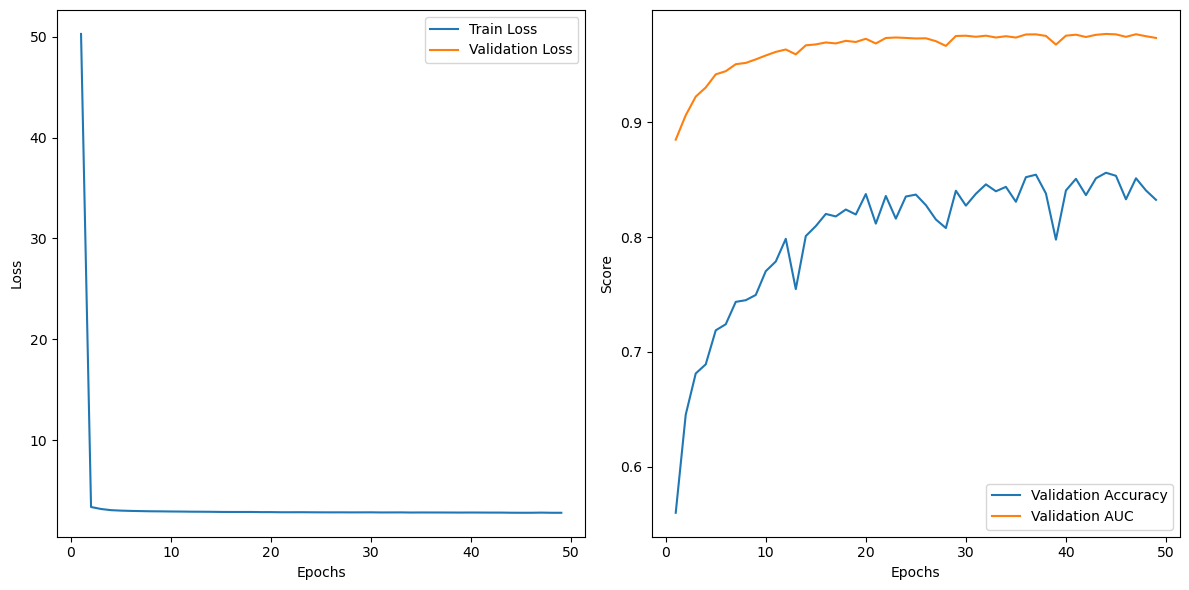

C:\Users\Citrus柚子\AppData\Local\Temp\ipykernel_21424\1467271849.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [30]:
# 绘制训练过程中的趋势图
plt.figure(figsize=(12, 6))

# 绘制训练和验证损失
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制验证准确率和AUC
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, len(val_auc_scores) + 1), val_auc_scores, label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))

In [46]:

class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, optimizer, scheduler,
                 loss_fn_classification, loss_fn_decoder, loss_weights, device,
                 early_stopping_patience=5, epochs=50, tensorboard_logdir = 'logs'):
        """
        初始化训练器
        :param model: PyTorch 模型
        :param train_dataloader: 训练数据加载器
        :param val_dataloader: 验证数据加载器
        :param optimizer: 优化器
        :param scheduler: 学习率调度器
        :param loss_fn_classification: 分类任务的损失函数
        :param loss_fn_decoder: 解码器任务的损失函数
        :param loss_weights: 损失权重
        :param device: 设备 ('cuda' 或 'cpu')
        :param early_stopping_patience: 早停的容忍次数
        :param epochs: 总训练轮数
        """
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn_classification = loss_fn_classification
        self.loss_fn_decoder = loss_fn_decoder
        self.loss_weights = loss_weights
        self.device = device
        self.epochs = epochs
        self.early_stopping_patience = early_stopping_patience
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.val_auc_scores = []

        # 初始化 TensorBoard
        self.writer = SummaryWriter(tensorboard_logdir)

        # 模型参数初始化
        # self.init_weights()

    def init_weights(self):
        """
        模型参数初始化：使用 Xavier 初始化
        """
        def _init_fn(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        self.model.apply(_init_fn)
        print("Model parameters initialized using Xavier initialization.")


    def train_epoch(self):
        """
        单个 epoch 的训练过程
        :return: 平均训练损失
        """
        self.model.train()
        total_loss = 0

        for batch in self.train_dataloader:
            self.optimizer.zero_grad()

            # 将数据移到设备
            categorical_data = batch['categorical'].to(self.device)
            numerical_data = batch['numerical'].to(self.device)
            target = batch['target'].to(self.device)

            # 合并特征
            data = torch.cat([categorical_data, numerical_data], dim=1)

            # 前向传播
            autoencoder_classification, final_output, decoded_output = self.model(data)

            # 计算损失
            loss_classification = self.loss_fn_classification(autoencoder_classification, target)
            loss_final_output = self.loss_fn_classification(final_output, target)
            loss_decoder = self.loss_fn_decoder(decoded_output, data)

            # 加权损失
            loss = (self.loss_weights['Autoencoder_Classification'] * loss_classification +
                    self.loss_weights['Final_Output'] * loss_final_output +
                    self.loss_weights['Decoder_Output'] * loss_decoder)

            # 反向传播
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(self.train_dataloader)

    def validate(self):
        """
        验证过程
        :return: 验证损失、验证准确率、验证 AUC
        """
        self.model.eval()
        val_loss = 0
        val_predictions = []
        val_labels = []
        final_output_list = []

        with torch.no_grad():
            for batch in self.val_dataloader:
                # 将数据移到设备
                categorical_data = batch['categorical'].to(self.device)
                numerical_data = batch['numerical'].to(self.device)
                target = batch['target'].to(self.device)

                # 合并特征
                data = torch.cat([categorical_data, numerical_data], dim=1)

                # 前向传播
                autoencoder_classification, final_output, decoded_output = self.model(data)

                # 计算损失
                loss_classification = self.loss_fn_classification(autoencoder_classification, target)
                loss_final_output = self.loss_fn_classification(final_output, target)
                loss_decoder = self.loss_fn_decoder(decoded_output, data)
                val_loss += (self.loss_weights['Autoencoder_Classification'] * loss_classification +
                             self.loss_weights['Final_Output'] * loss_final_output +
                             self.loss_weights['Decoder_Output'] * loss_decoder)

                # 收集预测结果
                val_predictions.append(final_output.argmax(dim=1).cpu().numpy())
                val_labels.append(target.cpu().numpy())
                final_output_list.append(final_output.cpu().numpy())

        # 合并预测结果
        val_predictions = np.concatenate(val_predictions, axis=0)
        val_labels = np.concatenate(val_labels, axis=0)
        final_output = np.concatenate(final_output_list, axis=0)

        # 计算评估指标
        val_accuracy = accuracy_score(val_labels, val_predictions)
        val_auc = roc_auc_score(val_labels, final_output, multi_class='ovr', average='macro')

        return val_loss / len(self.val_dataloader), val_accuracy, val_auc

    def fit(self):
        """
        开始训练
        """
        for epoch in tqdm(range(self.epochs), desc="Training Progress"):

            train_loss = self.train_epoch()
            val_loss, val_accuracy, val_auc = self.validate()

            # 记录损失和评估指标
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            self.val_auc_scores.append(val_auc)

            # 将数据写入 TensorBoard
            self.writer.add_scalar('Loss/Train', train_loss, epoch)
            self.writer.add_scalar('Loss/Validation', val_loss, epoch)
            self.writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)
            self.writer.add_scalar('AUC/Validation', val_auc, epoch)

            print(f"Epoch {epoch+1}/{self.epochs} | Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Val AUC: {val_auc:.4f}")

            # 调度学习率
            if self.scheduler:
                self.scheduler.step()

            # 早停机制
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.save_model('best_model.pth')
            else:
                self.patience_counter += 1
                if self.patience_counter >= self.early_stopping_patience:
                    print("Early stopping triggered.")
                    break

    def save_model(self, path):
        """
        保存模型
        """
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        """
        加载模型
        """
        self.model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")


In [47]:
# 模型和优化器
model = CustomModel(input_dim=16, num_classes=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 损失函数和权重
loss_fn_classification = nn.CrossEntropyLoss()
loss_fn_decoder = nn.MSELoss()
loss_weights = {
    "Autoencoder_Classification": 0.8,
    "Final_Output": 1.0,
    "Decoder_Output": 0.8
}

# 实例化 Trainer
trainer = Trainer(model, train_dataloader, val_dataloader, optimizer, scheduler,
                  loss_fn_classification, loss_fn_decoder, loss_weights, device,
                  early_stopping_patience=5, epochs=30, tensorboard_logdir='logs')

# 开始训练
trainer.fit()


Training Progress:   3%|▎         | 1/30 [00:10<04:50, 10.02s/it]

Epoch 1/30 | Train Loss: 52.1102 | Val Loss: 6.2127 | Val Accuracy: 0.4562 | Val AUC: 0.6953
Model saved to best_model.pth


Training Progress:   7%|▋         | 2/30 [00:20<04:40, 10.02s/it]

Epoch 2/30 | Train Loss: 4.6105 | Val Loss: 3.4685 | Val Accuracy: 0.4940 | Val AUC: 0.7360
Model saved to best_model.pth


Training Progress:  10%|█         | 3/30 [00:30<04:34, 10.18s/it]

Epoch 3/30 | Train Loss: 3.4389 | Val Loss: 3.3808 | Val Accuracy: 0.5055 | Val AUC: 0.7397
Model saved to best_model.pth


Training Progress:  13%|█▎        | 4/30 [00:41<04:30, 10.40s/it]

Epoch 4/30 | Train Loss: 3.3973 | Val Loss: 3.3550 | Val Accuracy: 0.5154 | Val AUC: 0.7404
Model saved to best_model.pth


Training Progress:  17%|█▋        | 5/30 [00:51<04:16, 10.26s/it]

Epoch 5/30 | Train Loss: 3.3501 | Val Loss: 3.2670 | Val Accuracy: 0.5226 | Val AUC: 0.7407
Model saved to best_model.pth


Training Progress:  20%|██        | 6/30 [01:00<04:02, 10.09s/it]

Epoch 6/30 | Train Loss: 3.2736 | Val Loss: 3.2561 | Val Accuracy: 0.5282 | Val AUC: 0.7446
Model saved to best_model.pth


Training Progress:  23%|██▎       | 7/30 [01:11<03:52, 10.10s/it]

Epoch 7/30 | Train Loss: 3.2599 | Val Loss: 3.2183 | Val Accuracy: 0.5287 | Val AUC: 0.7486
Model saved to best_model.pth


Training Progress:  27%|██▋       | 8/30 [01:21<03:43, 10.14s/it]

Epoch 8/30 | Train Loss: 3.2509 | Val Loss: 3.2348 | Val Accuracy: 0.5306 | Val AUC: 0.7560


Training Progress:  30%|███       | 9/30 [01:32<03:41, 10.54s/it]

Epoch 9/30 | Train Loss: 3.2418 | Val Loss: 3.2432 | Val Accuracy: 0.5352 | Val AUC: 0.7533


Training Progress:  33%|███▎      | 10/30 [01:43<03:30, 10.54s/it]

Epoch 10/30 | Train Loss: 3.2387 | Val Loss: 3.2199 | Val Accuracy: 0.5236 | Val AUC: 0.7460


Training Progress:  37%|███▋      | 11/30 [01:53<03:18, 10.45s/it]

Epoch 11/30 | Train Loss: 3.2122 | Val Loss: 3.1975 | Val Accuracy: 0.5354 | Val AUC: 0.7566
Model saved to best_model.pth


Training Progress:  40%|████      | 12/30 [02:03<03:06, 10.37s/it]

Epoch 12/30 | Train Loss: 3.2106 | Val Loss: 3.1973 | Val Accuracy: 0.5337 | Val AUC: 0.7536
Model saved to best_model.pth


Training Progress:  43%|████▎     | 13/30 [02:13<02:55, 10.30s/it]

Epoch 13/30 | Train Loss: 3.2096 | Val Loss: 3.1948 | Val Accuracy: 0.5354 | Val AUC: 0.7586
Model saved to best_model.pth


Training Progress:  47%|████▋     | 14/30 [02:23<02:44, 10.26s/it]

Epoch 14/30 | Train Loss: 3.2099 | Val Loss: 3.1983 | Val Accuracy: 0.5371 | Val AUC: 0.7580


Training Progress:  50%|█████     | 15/30 [02:34<02:33, 10.24s/it]

Epoch 15/30 | Train Loss: 3.2092 | Val Loss: 3.1959 | Val Accuracy: 0.5371 | Val AUC: 0.7571


Training Progress:  53%|█████▎    | 16/30 [02:44<02:23, 10.24s/it]

Epoch 16/30 | Train Loss: 3.2081 | Val Loss: 3.1922 | Val Accuracy: 0.5388 | Val AUC: 0.7593
Model saved to best_model.pth


Training Progress:  57%|█████▋    | 17/30 [02:54<02:12, 10.22s/it]

Epoch 17/30 | Train Loss: 3.2087 | Val Loss: 3.1918 | Val Accuracy: 0.5368 | Val AUC: 0.7605
Model saved to best_model.pth


Training Progress:  60%|██████    | 18/30 [03:04<02:01, 10.09s/it]

Epoch 18/30 | Train Loss: 3.2072 | Val Loss: 3.1912 | Val Accuracy: 0.5390 | Val AUC: 0.7583
Model saved to best_model.pth


Training Progress:  63%|██████▎   | 19/30 [03:20<02:09, 11.80s/it]

Epoch 19/30 | Train Loss: 3.2059 | Val Loss: 3.1902 | Val Accuracy: 0.5383 | Val AUC: 0.7595
Model saved to best_model.pth


Training Progress:  67%|██████▋   | 20/30 [03:39<02:19, 13.98s/it]

Epoch 20/30 | Train Loss: 3.2062 | Val Loss: 3.1911 | Val Accuracy: 0.5381 | Val AUC: 0.7616


Training Progress:  70%|███████   | 21/30 [03:58<02:20, 15.66s/it]

Epoch 21/30 | Train Loss: 3.2024 | Val Loss: 3.1877 | Val Accuracy: 0.5395 | Val AUC: 0.7603
Model saved to best_model.pth


Training Progress:  73%|███████▎  | 22/30 [04:09<01:54, 14.26s/it]

Epoch 22/30 | Train Loss: 3.2021 | Val Loss: 3.1876 | Val Accuracy: 0.5395 | Val AUC: 0.7612
Model saved to best_model.pth


Training Progress:  77%|███████▋  | 23/30 [04:19<01:30, 12.92s/it]

Epoch 23/30 | Train Loss: 3.2020 | Val Loss: 3.1868 | Val Accuracy: 0.5400 | Val AUC: 0.7610
Model saved to best_model.pth


Training Progress:  80%|████████  | 24/30 [04:29<01:11, 11.92s/it]

Epoch 24/30 | Train Loss: 3.2019 | Val Loss: 3.1868 | Val Accuracy: 0.5402 | Val AUC: 0.7608
Model saved to best_model.pth


Training Progress:  83%|████████▎ | 25/30 [04:39<00:56, 11.40s/it]

Epoch 25/30 | Train Loss: 3.2018 | Val Loss: 3.1867 | Val Accuracy: 0.5395 | Val AUC: 0.7613
Model saved to best_model.pth


Training Progress:  87%|████████▋ | 26/30 [04:49<00:43, 10.90s/it]

Epoch 26/30 | Train Loss: 3.2016 | Val Loss: 3.1893 | Val Accuracy: 0.5402 | Val AUC: 0.7592


Training Progress:  90%|█████████ | 27/30 [04:58<00:31, 10.58s/it]

Epoch 27/30 | Train Loss: 3.2019 | Val Loss: 3.1866 | Val Accuracy: 0.5405 | Val AUC: 0.7602
Model saved to best_model.pth


Training Progress:  90%|█████████ | 27/30 [05:02<00:33, 11.21s/it]


KeyboardInterrupt: 